# 勾配降下法を地形に適用する

- [地理院タイル一覧](http://maps.gsi.go.jp/development/ichiran.html)
- [タイル座標確認ページ](http://maps.gsi.go.jp/development/tileCoordCheck.html)
- [地理院タイル仕様](http://maps.gsi.go.jp/development/siyou.html)
- [標高タイルの詳細仕様](http://maps.gsi.go.jp/development/demtile.html)

## 1. 準備
### 1.1 import

In [1]:
import urllib
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

### 1.2 地理院タイルをダウンロードする関数・arrayとして取り込む関数

In [2]:
def maybe_download(url, name):
    """ ファイルがなければダウンロード """
    if not os.path.exists(name):
        urllib.urlretrieve(url, name)
        print "File " + name + " downloaded!"
    return name

def read_tile(name):
    """ csv file -> numpy array """
    ret = np.genfromtxt(name, delimiter=",", filling_values=0.) # 'e' -> 0.0 （海など?）
    if ret.shape == (256, 256):
        return ret
    else: # 国外だとデータがないので0としておく
        return np.zeros((256, 256))

### 1.3 任意の領域・ズームレベルで標高タイルを取得する関数
#### 領域の定義
- [タイル座標確認ページ](http://maps.gsi.go.jp/development/tileCoordCheck.html)を開き、長方形領域の左上と右下のタイル座標を好きなズームレベルで指定する。
- 例えば、以下の画像で5/27/11から5/28/13までの縦長領域に関して好きなズームレベルで標高タイルを取得したいとする。
<img src="fig/japan.png" width="500">

#### タイル座標の取得
上記で指定した領域について、任意のズームレベルにおけるタイル座標をすべて取得する。

ズームレベルを1つ増やすごとにタイルが4倍になり、下図のようにタイル座標が変化することに注意。
<img src="fig/zoom.jpg" width="400">

In [3]:
def get_tiles(from_tile, to_tile=None, zoom=None):
    """ 指定された領域に含まれるすべての標高タイルを任意のズームレベルで取得する
    Inputs:
        from_tile, to_tile: 取得したい領域内の左上、右下のタイル座標（それぞれ[z, x, y]のリスト）
        zoom: ズームレベル
    Outputs:
        full_tile: 指定した領域の標高タイルを結合したもの（numpyのarray）
    """
    if zoom == None:# zoomを省略するとfrom_tileと同じになる
        zoom =from_tile[0]
    if to_tile == None:# to_tileを省略するとfrom_tileと同じになる
        to_tile = from_tile
    MAX_ZOOM = 18
    assert zoom <= MAX_ZOOM

    # 指定されたzoomにおける左上のタイル座標
    x1 = from_tile[1] * 2**(zoom - from_tile[0])
    y1 = from_tile[2] * 2**(zoom - from_tile[0])
    # 指定されたzoomにおける右下のタイル座標
    x2 = (to_tile[1] + 1) * 2**(zoom - to_tile[0]) - 1 # すぐ右下を考え、それから-1
    y2 = (to_tile[2] + 1) * 2**(zoom - to_tile[0]) - 1 # すぐ右下を考え、それから-1
    
    # 左上〜右下すべてのタイルの座標
    tile_list = []
    for j in range(y1, y2+1):
        tile_row = []
        for i in range(x1, x2+1):
            tile_row.append([zoom, i, j])
        tile_list.append(tile_row)
    
    # ダウンロード
    full_tile = []
    for tile_row in tile_list:
        tr = []
        for tile in tile_row:
            tile_url = "http://cyberjapandata.gsi.go.jp/xyz/dem/{z}/{x}/{y}.txt".format(z=tile[0], x=tile[1], y=tile[2])
            tile_name = "csv/dem_{z}_{x}_{y}.csv".format(z=tile[0], x=tile[1], y=tile[2])
            maybe_download(tile_url, tile_name)
            tr.append(read_tile(tile_name)) # 'e'->0.0
        full_tile.append(np.hstack(tr))
    full_tile = np.vstack(full_tile)
    return full_tile

#### Usage

(256, 256)
(768, 512)
(3072, 2048)


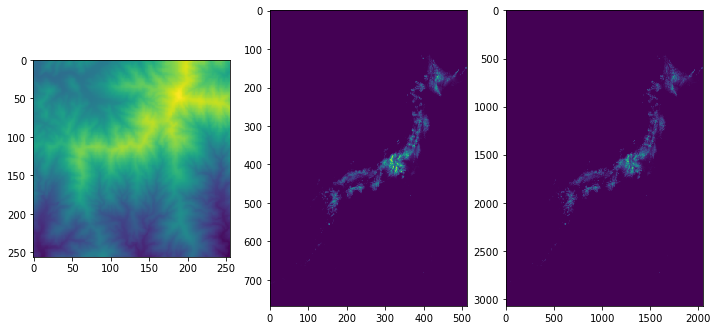

In [4]:
# タイル座標13/7262/3232のタイルを取得したい場合
nabewari_tile = get_tiles([13, 7262, 3232]) # 引数にタイル座標を1つだけ渡す
print nabewari_tile.shape # 地理院タイルは1つあたり256x256

# タイル座標5/27/11から5/28/13のタイルをまとめて取得したい場合
japan_tile = get_tiles([5, 27, 11], [5, 28, 13])
print japan_tile.shape

# 同じくタイル座標5/27/11から5/28/13のタイルを、もっと細かく（ズームレベル7で）取得したい場合
japan_tile2 = get_tiles([5, 27, 11], [5, 28, 13], 7)
print japan_tile2.shape

# plot
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(nabewari_tile, interpolation="none")

ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(japan_tile, interpolation="none")

ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(japan_tile2, interpolation="none")

### 1.4 任意の領域・ズームレベルで地図を取得する関数
ほぼget_tiles()のコピペ。統合すればよいのでは？というのはある

In [5]:
def get_maps(from_tile, to_tile=None, zoom=None):
    """ 指定された領域に含まれるすべての地図タイルを任意のズームレベルで取得する
    Inputs:
        from_tile, to_tile: 取得したい領域内の左上、右下のタイル座標（それぞれ[z, x, y]のリスト）
        zoom: ズームレベル
    Outputs:
        full_tile: 指定した領域の地図タイルを結合したもの（numpyのarray）
    """
    if zoom == None:# zoomを省略するとfrom_tileと同じになる
        zoom =from_tile[0]
    if to_tile == None:# to_tileを省略するとfrom_tileと同じになる
        to_tile = from_tile
    MAX_ZOOM = 18
    assert zoom <= MAX_ZOOM

    # 指定されたzoomにおける左上のタイル座標
    x1 = from_tile[1] * 2**(zoom - from_tile[0])
    y1 = from_tile[2] * 2**(zoom - from_tile[0])
    # 指定されたzoomにおける右下のタイル座標
    x2 = (to_tile[1] + 1) * 2**(zoom - to_tile[0]) - 1 # すぐ右下を考え、それから-1
    y2 = (to_tile[2] + 1) * 2**(zoom - to_tile[0]) - 1 # すぐ右下を考え、それから-1
    
    # 左上〜右下すべてのタイルの座標
    tile_list = []
    for j in range(y1, y2+1):
        tile_row = []
        for i in range(x1, x2+1):
            tile_row.append([zoom, i, j])
        tile_list.append(tile_row)
    
    # ダウンロード
    full_tile = []
    for tile_row in tile_list:
        tr = []
        for tile in tile_row:
            tile_url = "http://cyberjapandata.gsi.go.jp/xyz/std/{z}/{x}/{y}.png".format(z=tile[0], x=tile[1], y=tile[2])
            tile_name = "png/std_{z}_{x}_{y}.png".format(z=tile[0], x=tile[1], y=tile[2])
            maybe_download(tile_url, tile_name)
            tr.append(np.array(Image.open(tile_name)))
        full_tile.append(np.hstack(tr))
    full_tile = np.vstack(full_tile)
    return full_tile

#### Usage

(768, 512, 3)


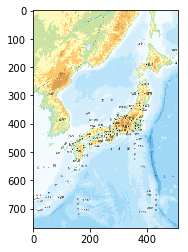

In [6]:
japan_map = get_maps([5, 27, 11], [5, 28, 13])
print japan_map.shape
plt.imshow(japan_map)

## 2. 勾配の計算

### 2.1 勾配の計算方法
地理院タイルでは格子点上の標高が記されている（下図の正方形の頂点）。その隙間の任意の地点$(x, y)$での勾配を知りたいので、下図の右下のように各格子を2つの三角形（上から見ると直角二等辺三角形に見える）に分割し、その平面の方程式を通して勾配を計算する。
<img src="fig/grad.png", width=400></img>
- (1) 点$(x, y)$が$(x-[x])+(y-[y]) < 1$を満たす（図の灰色の三角形に属する）とき:

    3点$([x],\: [y],\: z_0),\: ([x]+1,\: [y],\: z_1),\: ([x],\: [y]+1,\: z_2)$を通る平面の方程式を求め、$\frac{\partial z}{\partial x},\:\frac{\partial z}{\partial y}$を計算すると

$$
\frac{\partial z}{\partial x} = z_1 - z_0, \: \: \frac{\partial z}{\partial y} = z_2 - z_0
$$

- (2) 点$(x, y)$が$(x-[x])+(y-[y]) \geq 1$を満たす（図の水色の三角形に属する）とき:

    3点$([x]+1,\: [y]+1,\: z_3),\: ([x]+1,\: [y],\: z_1),\: ([x],\: [y]+1,\: z_2)$を通る平面の方程式を求め、$\frac{\partial z}{\partial x},\:\frac{\partial z}{\partial y}$を計算すると

$$
\frac{\partial z}{\partial x} = z_3 - z_2, \: \: \frac{\partial z}{\partial y} = z_3 - z_1
$$

In [7]:
def gradient(tile, x, y):
    """ 指定された標高タイル上の任意の地点での勾配を計算する
    Inputs: 
        tile: 標高タイル
        x, y: 勾配を計算したい地点の座標
    Outputs:
        grad_x, grad_y: 勾配のx, y成分
    """
    fx, fy = int(x), int(y) # floor
    dx, dy = x-int(x), y-int(y) # decimal part
    if (dx + dy) < 1:
        grad_x = tile[fy, fx+1] - tile[fy, fx]
        grad_y = tile[fy+1, fx] - tile[fy, fx]
    else:
        grad_x = tile[fy+1, fx+1] - tile[fy+1, fx]
        grad_y = tile[fy+1, fx+1] - tile[fy, fx+1]
    return grad_x, grad_y

- 標高はメートルなのに対してx, yはズームレベルにより異なることに注意。勾配降下法を用いる分には問題ない。

In [1]:
# Usage
print gradient(nabewari_tile, 12.34, 56.78)

NameError: name 'gradient' is not defined

### 2.2 勾配の可視化

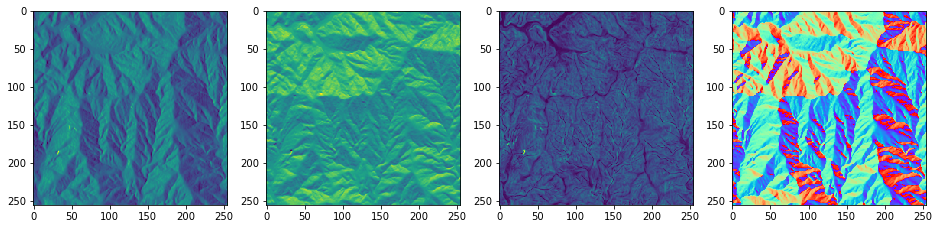

In [9]:
gx = np.zeros((nabewari_tile.shape[0]-1, nabewari_tile.shape[1]-1)) # x方向の勾配
gy = np.zeros((nabewari_tile.shape[0]-1, nabewari_tile.shape[1]-1)) # y方向の勾配
g  = np.zeros((nabewari_tile.shape[0]-1, nabewari_tile.shape[1]-1)) # 勾配の絶対値
gt = np.zeros((nabewari_tile.shape[0]-1, nabewari_tile.shape[1]-1)) # 勾配の方向

for i in range(nabewari_tile.shape[0]-1):
    for j in range(nabewari_tile.shape[1]-1):
        gx[i, j] = gradient(nabewari_tile, j, i)[0]
        gy[i, j] = gradient(nabewari_tile, j, i)[1]
        g[i, j] = np.sqrt(gradient(nabewari_tile, j, i)[0]**2 + gradient(nabewari_tile, j, i)[1]**2)
        gt[i, j] = np.arctan2(gradient(nabewari_tile, j, i)[1], gradient(nabewari_tile, j, i)[0])

# plot
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 4, 1)
ax.imshow(gx, interpolation="none")

ax2 = fig.add_subplot(1, 4, 2)
ax2.imshow(gy, interpolation="none")

ax3 = fig.add_subplot(1, 4, 3)
ax3.imshow(g, interpolation="none")

ax4 = fig.add_subplot(1, 4, 4)
ax4.imshow(gt, interpolation="none", cmap="rainbow")

## 3. Gradient Descentで坂を下る
初期地点を$(x_0, y_0)$として、以下のように勾配を下る
$$
\begin{align}
x_{k+1} = x_{k} - \epsilon \frac{\partial z}{\partial x} \\
y_{k+1} = y_{k} - \epsilon \frac{\partial z}{\partial y}
\end{align}
$$

TODO: Momentum, etc

http://postd.cc/optimizing-gradient-descent/

http://distill.pub/2017/momentum/

In [10]:
# 以下を考慮してεのオーダーを考える（このgx, gyはnabewari_tileの各点でのgradientを収めたarray）
print gx.min(), gx.max()
print gy.min(), gy.max()

-26.07 47.56
-39.54 27.63


In [45]:
nabewari_tile.shape

(256, 256)

In [46]:
def show_gradient_descent(tile, start_point, eps=0.1, max_step=1000, map_=None):
    """ 勾配降下法で斜面を下る過程を可視化する
    Inputs:
        tile: 標高タイル
        start_point: 下り始める地点(x,y)
        eps: 座標の更新の係数
        max_step: 最大ステップ数
        map_: tileに対応する領域の地図画像
    Outputs:
        returnせず、グラフを描画
    """
    x, y = start_point
    x_list = [x]
    y_list = [y]
    for _ in range(max_step):
        try:
            gx, gy = gradient(tile, x, y)
        except IndexError:
            break
        x = x - eps * gx
        y = y - eps * gy
        x_list.append(x)
        y_list.append(y)
    
    # visualize
    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_list)
    plt.xlabel("step"), plt.ylabel("x")
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(y_list)
    plt.xlabel("step"), plt.ylabel("y")

    if map_ is not None:
        fig = plt.figure(figsize=(16, 6))
        ax = fig.add_subplot(1, 2, 1)
        im = ax.imshow(tile, interpolation="none")
        ax.plot(x_list, y_list, color="red")
        plt.colorbar(im)
        ax2 = fig.add_subplot(1, 2, 2)
        ax2.imshow(map_)
        ax2.plot(x_list, y_list, color="red")
    else:
        fig = plt.figure(figsize=(8, 6))
        plt.imshow(tile, interpolation="none")
        plt.plot(x_list, y_list, color="red")
        plt.colorbar()

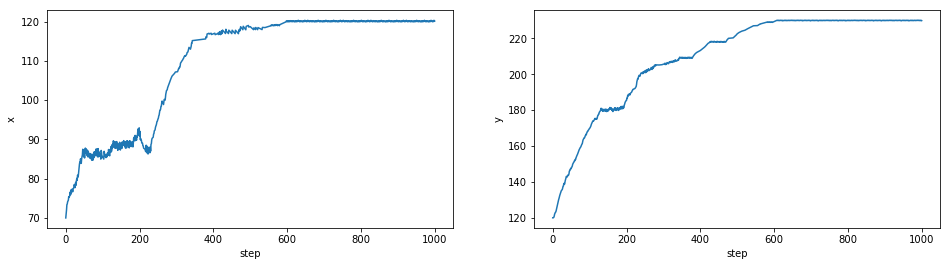

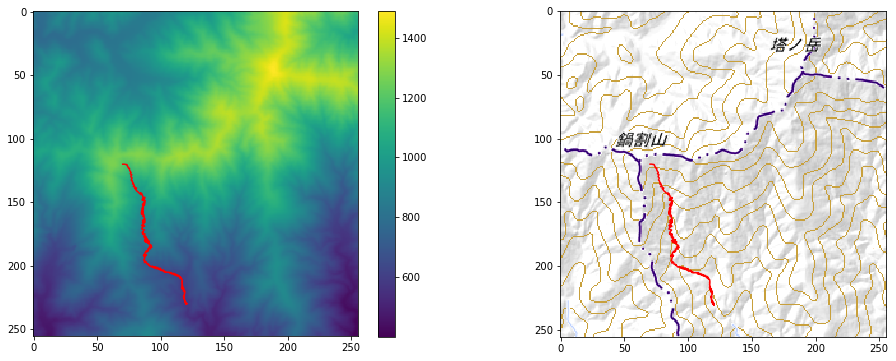

In [47]:
nabewari_tile = get_tiles([13, 7262, 3232]) # 引数にタイル座標を1つだけ渡す
nabewari_map = get_maps([13, 7262, 3232])
show_gradient_descent(nabewari_tile, (70, 120), map_=nabewari_map)

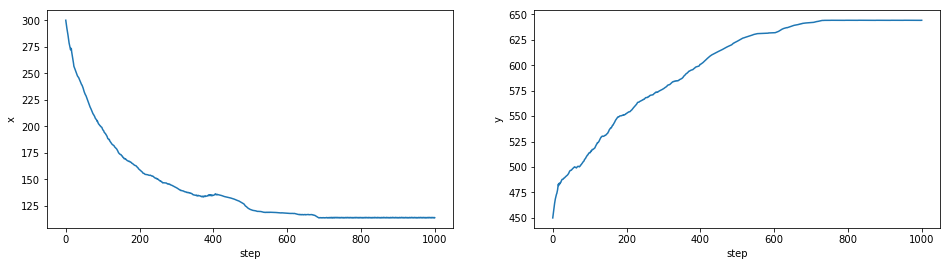

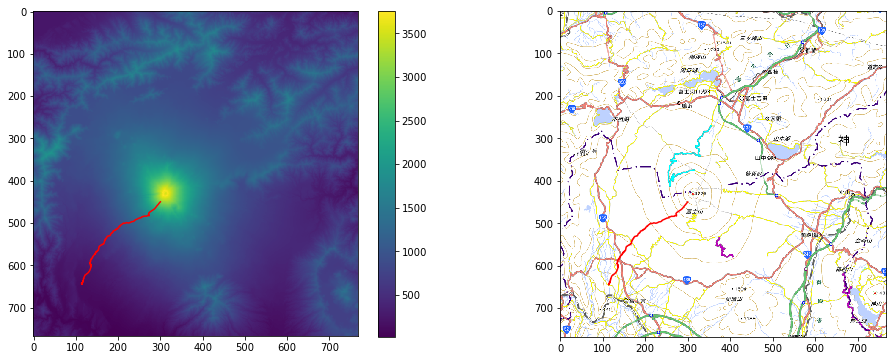

In [48]:
# 富士山
fuji_tile = get_tiles([11, 1812, 807], [11, 1814, 809])
fuji_map = get_maps([11, 1812, 807], [11, 1814, 809])
show_gradient_descent(fuji_tile, (300, 450), map_=fuji_map)

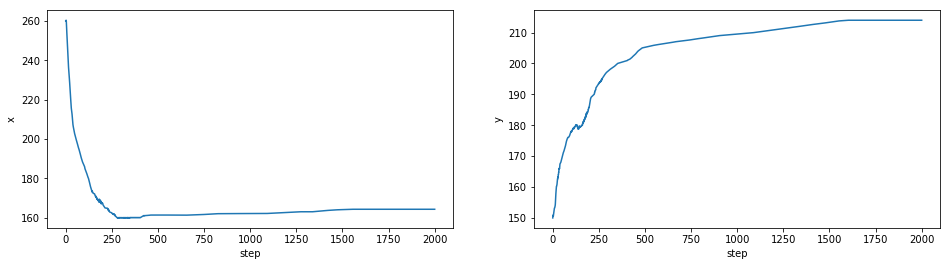

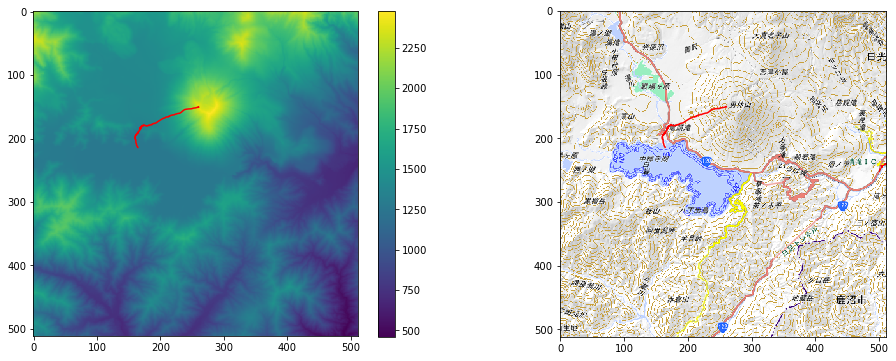

In [49]:
# 男体山から中禅寺湖へ
nikko_tile = get_tiles([12, 3634, 1597], [12, 3635, 1598])
nikko_map = get_maps([12, 3634, 1597], [12, 3635, 1598])
show_gradient_descent(nikko_tile, (260, 150), eps=0.1, max_step=2000, map_=nikko_map)

## 4. いろいろな所から下る

In [103]:
path_x_list = []
path_y_list = []
max_step = 2000
eps = 0.1
tile = nabewari_tile
for i in range(10, 255, 10):
    for j in range(10, 255, 10):
        x, y = i, j
        x_list = [x]
        y_list = [y]
        for _ in range(max_step):
            try:
                gx, gy = gradient(tile, x, y)
            except IndexError:
                break
            x = x - eps * gx
            y = y - eps * gy
            if 0<x and x<nabewari_tile.shape[1] and 0<y and y<nabewari_tile.shape[0]:
                x_list.append(x)
                y_list.append(y)
        path_x_list.append(x_list)
        path_y_list.append(y_list)

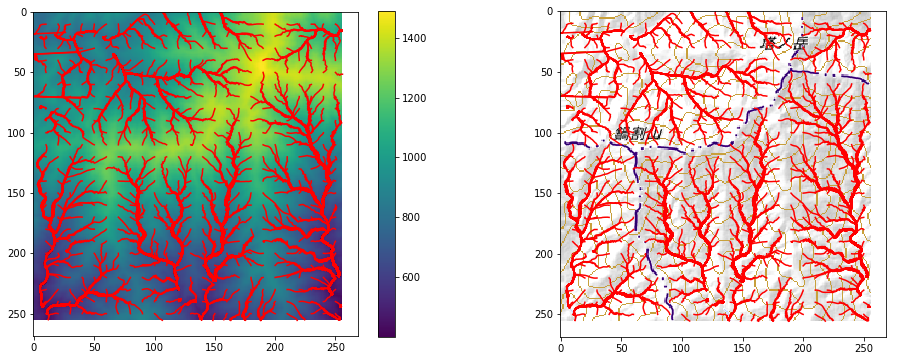

In [104]:
 # visualize

map_ = nabewari_map

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(1, 2, 1)
im = ax.imshow(tile, interpolation="none")
for xl, yl in zip(path_x_list, path_y_list):
    ax.plot(xl, yl, color="red")
plt.colorbar(im)
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(map_)
for xl, yl in zip(path_x_list, path_y_list):
    ax2.plot(xl, yl, color="red")

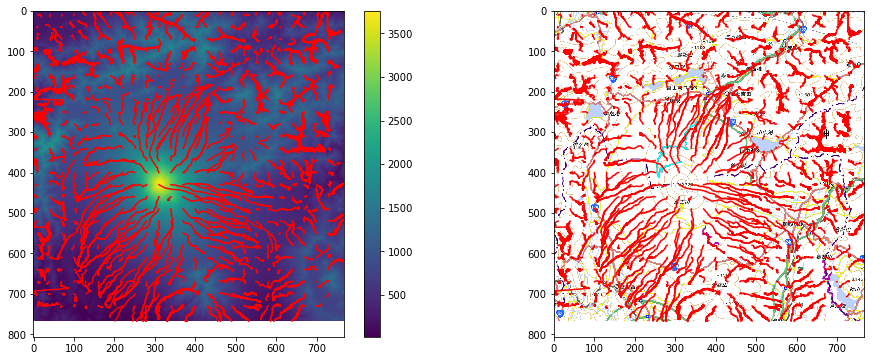

In [107]:
path_x_list = []
path_y_list = []
max_step = 3000
eps = 0.1
tile = fuji_tile
map_ = fuji_map

for i in range(10, 760, 30):
    for j in range(10, 760, 30):
        x, y = i, j
        x_list = [x]
        y_list = [y]
        for _ in range(max_step):
            try:
                gx, gy = gradient(tile, x, y)
            except IndexError:
                break
            x = x - eps * gx
            y = y - eps * gy
            if 0<x and x<tile.shape[1] and 0<y and y<tile.shape[0]:
                x_list.append(x)
                y_list.append(y)
        path_x_list.append(x_list)
        path_y_list.append(y_list)
        
# visualize
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(1, 2, 1)
im = ax.imshow(tile, interpolation="none")
for xl, yl in zip(path_x_list, path_y_list):
    ax.plot(xl, yl, color="red")
plt.colorbar(im)
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(map_)
for xl, yl in zip(path_x_list, path_y_list):
    ax2.plot(xl, yl, color="red")

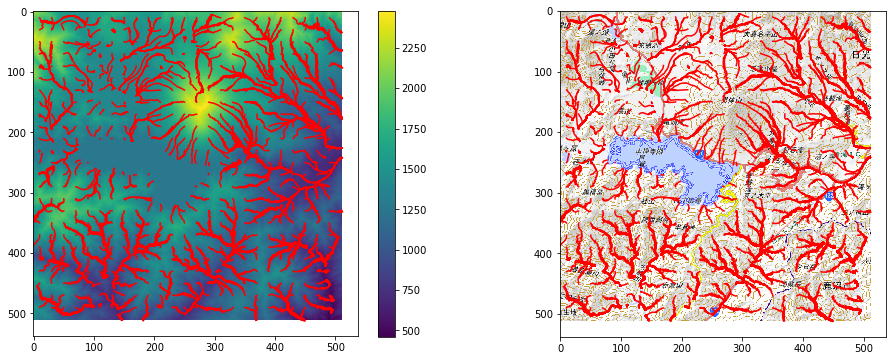

In [108]:
path_x_list = []
path_y_list = []
max_step = 2000
eps = 0.1
tile = nikko_tile
map_ = nikko_map

for i in range(10, 500, 20):
    for j in range(10, 500, 20):
        x, y = i, j
        x_list = [x]
        y_list = [y]
        for _ in range(max_step):
            try:
                gx, gy = gradient(tile, x, y)
            except IndexError:
                break
            x = x - eps * gx
            y = y - eps * gy
            if 0<x and x<tile.shape[1] and 0<y and y<tile.shape[0]:
                x_list.append(x)
                y_list.append(y)
        path_x_list.append(x_list)
        path_y_list.append(y_list)
        
# visualize
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(1, 2, 1)
im = ax.imshow(tile, interpolation="none")
for xl, yl in zip(path_x_list, path_y_list):
    ax.plot(xl, yl, color="red")
plt.colorbar(im)
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(map_)
for xl, yl in zip(path_x_list, path_y_list):
    ax2.plot(xl, yl, color="red")

## 5. 下り始めと到達地の関係

In [113]:
print path_x_list[0][0], path_x_list[0][-1]

10 84.998


In [117]:
for i, (px, py) in enumerate(zip(path_x_list, path_y_list)):
    print px[0], py[0], " -> ", px[-1], py[-1]

10 10  ->  84.998 22.692
10 30  ->  85.0 22.701
10 50  ->  30.011 194.037
10 70  ->  29.965 194.077
10 90  ->  29.97 194.06
10 110  ->  30.005 194.034
10 130  ->  20.083 179.955
10 150  ->  20.086 180.146
10 170  ->  20.204 179.929
10 190  ->  32.147 215.013
10 210  ->  32.089 215.035
10 230  ->  10.033 231.998
10 250  ->  14.004 235.001
10 270  ->  32.732 258.518
10 290  ->  31.836 257.441
10 310  ->  0.389 345.774
10 330  ->  0.168 346.526
10 350  ->  0.992 347.651
10 370  ->  0.094 387.324
10 390  ->  11.194 405.869
10 410  ->  13.15 409.193
10 430  ->  56.169 420.055
10 450  ->  99.185 489.064
10 470  ->  98.999 488.468
10 490  ->  98.92 488.138
30 10  ->  84.999 22.728
30 30  ->  85.0 22.806
30 50  ->  30.022 194.083
30 70  ->  29.989 194.072
30 90  ->  29.947 194.011
30 110  ->  30.011 194.009
30 130  ->  20.705 180.019
30 150  ->  29.974 194.072
30 170  ->  29.945 194.018
30 190  ->  29.975 194.039
30 210  ->  32.019 215.075
30 230  ->  32.042 233.7
30 250  ->  71.011 227.996
30

In [115]:
len(path_x_list)

625

In [147]:
hoge = np.zeros(len(path_x_list))
fuga = np.zeros(len(path_x_list))
hoge2 = np.zeros(len(path_x_list))
fuga2 = np.zeros(len(path_x_list))
for i, (px, py) in enumerate(zip(path_x_list, path_y_list)):
    hoge[i] = px[-1]
    fuga[i] = py[-1]
    hoge2[i] = px[0]
    fuga2[i] = py[0]

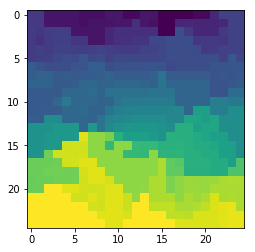

In [148]:
plt.imshow(hoge.reshape((25,25)))

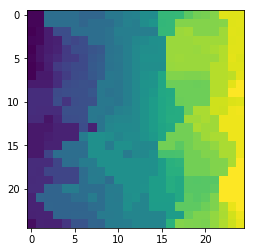

In [149]:
plt.imshow(fuga.reshape((25,25)))

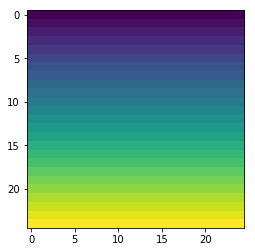

In [150]:
plt.imshow(hoge2.reshape((25, 25)))

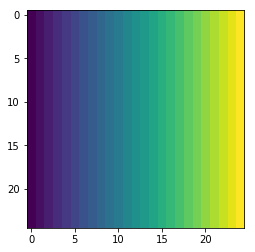

In [152]:
plt.imshow(fuga2.reshape((25, 25)))

In [134]:
np.array([hoge, fuga]).T.shape

(625, 2)

In [141]:
im = np.array([hoge.reshape(25,25),fuga.reshape(25, 25), np.zeros((25, 25))]).T
im.shape

(25, 25, 3)

In [153]:
im2 = np.array([hoge2.reshape(25,25),fuga2.reshape(25, 25), np.zeros((25, 25))]).T
im2.shape

(25, 25, 3)

In [154]:
im /= 2.
im2 /= 2.

In [155]:
im.max()

127.96824999999987

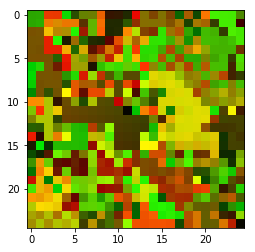

In [156]:
plt.imshow(im)

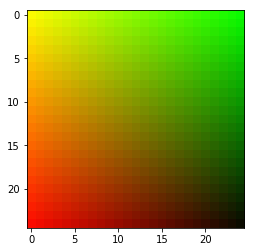

In [157]:
plt.imshow(im2)